## MSstatsTMT Analysis：Proteomics differential expression downstream analysis

#### The following Jupyter notebooks allows to perform differential expression data analysis from multiple pipelines developed by the bigbio team. The output of the following pipelines are supported: 

- [proteomicsTMT](https://github.com/bigbio/proteomicstmt): TMT pipeline based on OpenMS and nextflow.

For the data with isobaric labeling, using the [MSstatsTMT](https://www.bioconductor.org/packages/release/bioc/html/MSstatsTMT.html) to perform the downstream data analysis. Major steps in the data processing are the following:

- Importing data from the pipeline. The major source of data are:
  - out_msstats.csv

In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt
from venn import venn
import numpy as np


In [3]:
# preprocess out_msstats.csv

def remove_decoy(Pro):
    if "CONTAMINANT" in Pro or "DECOY_" in Pro:
        t = []
        for p in Pro.split(";"):
            if "CONTAMINANT" in p or "DECOY_" in p:
                pass
            else:
                t.append(p)
        if len(t) == 0:
            return None
        return ";".join(t)
    else:
        return Pro
    
data = pd.read_csv("../datasets/PXD009553/out_msstats.csv", sep=",")
data['ProteinName'] = data.apply(lambda x: remove_decoy(x.ProteinName), axis=1)
data.dropna(inplace=True)
data.to_csv("../datasets/PXD009553/out_msstats_pre.csv", index=False, sep=",")

In [4]:
%%R

data_folder = '../datasets/PXD009553'
setwd(data_folder)

In [5]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
openms_output = './out_msstats_pre.csv'
raw.om <- read.csv(openms_output, header = TRUE, sep = ',')
input.om <- OpenMStoMSstatsTMTFormat(raw.om)
head(input.om)

INFO  [2021-09-20 09:19:29] ** Raw data from OpenMS imported successfully.
INFO  [2021-09-20 09:19:30] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-09-20 09:19:30] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-09-20 09:19:30] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-09-20 09:19:30] ** Shared peptides are removed.
INFO  [2021-09-20 09:19:30] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-20 09:19:46] ** PSMs have been aggregated to peptide ions.
INFO  [2021-09-20 09:19:46] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-20 09:19:46] ** Fractionation handled.
INFO  [2021-

### Protein summarization, normalization and visualization

INFO  [2021-09-20 09:19:47] ** MSstatsTMT - proteinSummarization function
INFO  [2021-09-20 09:19:47] Summarizing for Run : 1_2_1 ( 1  of  12 )
  |======================================================================| 100%
INFO  [2021-09-20 09:19:55] Summarizing for Run : 3_8_1 ( 2  of  12 )
  |======================================================================| 100%
INFO  [2021-09-20 09:20:02] Summarizing for Run : 3_9_1 ( 3  of  12 )
  |======================================================================| 100%
INFO  [2021-09-20 09:20:10] Summarizing for Run : 1_1_1 ( 4  of  12 )
  |======================================================================| 100%
INFO  [2021-09-20 09:20:17] Summarizing for Run : 1_3_1 ( 5  of  12 )
  |======================================================================| 100%
INFO  [2021-09-20 09:20:26] Summarizing for Run : 2_4_1 ( 6  of  12 )
  |======================================================================| 100%
INFO  [2021-09-20 09:20:32

R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


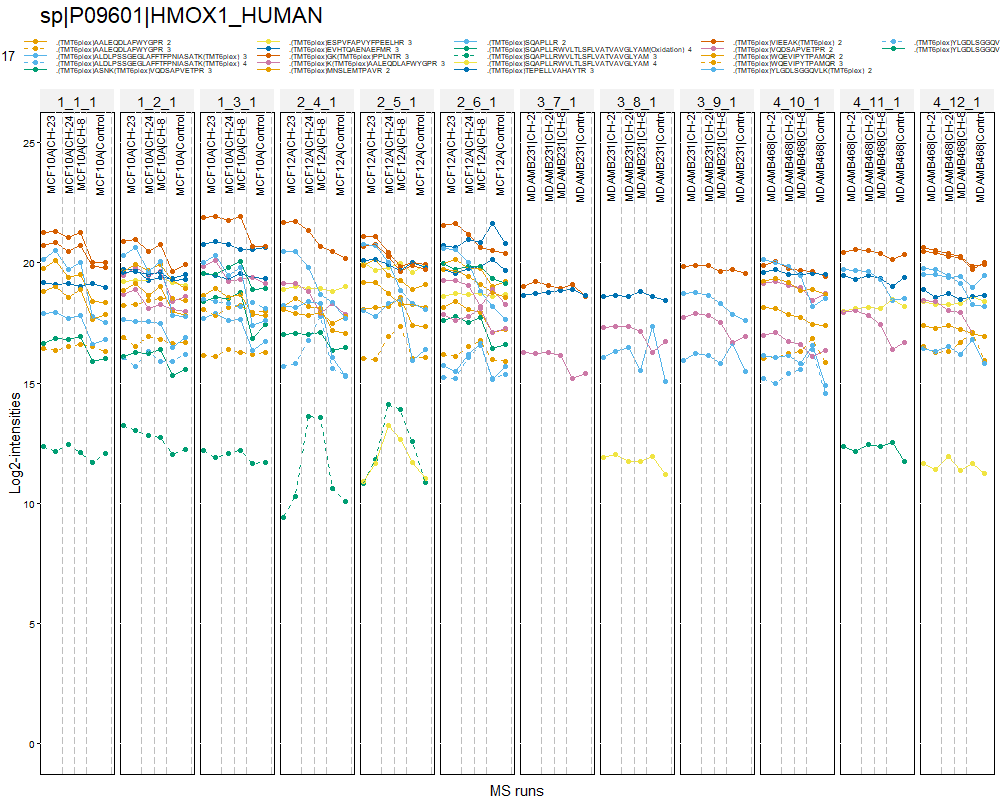

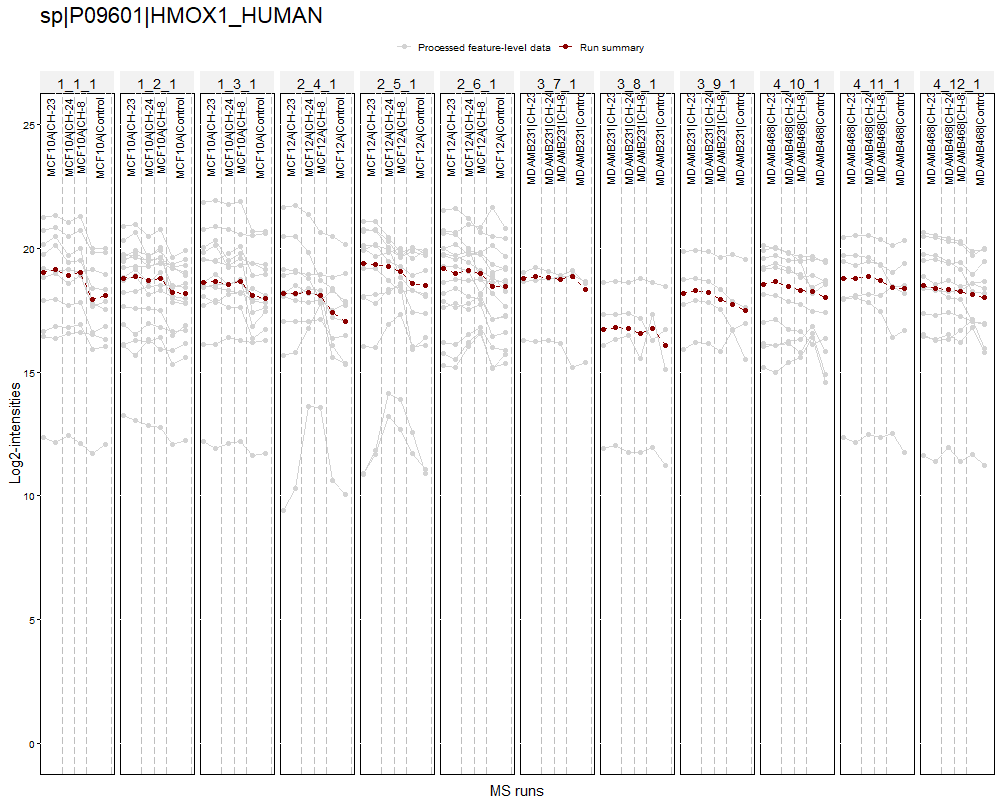

In [6]:
%%R -w 1000 -h 800

protein_expression = './protein_expression.csv'

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|P09601|HMOX1_HUMAN',
                     width = 21, # adjust the figure width 
                     height = 7,
                     address=FALSE)
TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]

write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)

R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



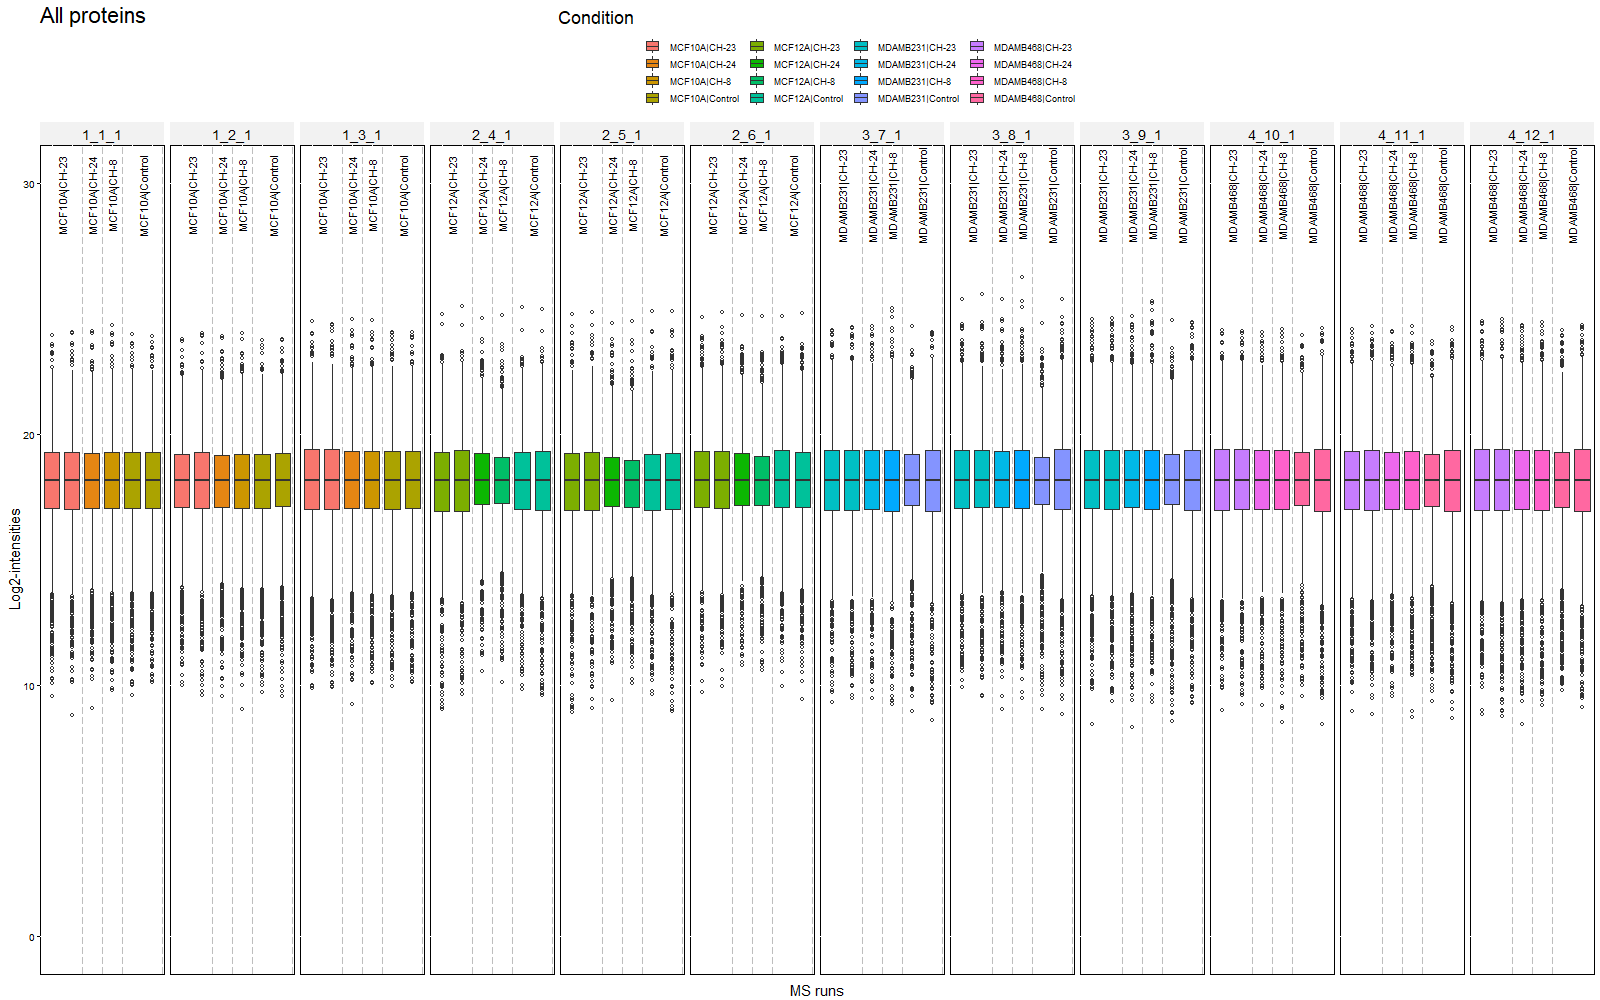

In [7]:
%%R -w 1600 -h 1000

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)
## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 21, # adjust the figure width
                     height = 12,
                     address = FALSE)

### Tests for significant changes in protein abundance across conditions

In [8]:
%%R
# Check the conditions in the protein level data
levels(quant_om.msstats$ProteinLevelData$Condition)

 [1] "MCF10A|CH-23"     "MCF10A|CH-24"     "MCF10A|CH-8"      "MCF10A|Control"  
 [5] "MCF12A|CH-23"     "MCF12A|CH-24"     "MCF12A|CH-8"      "MCF12A|Control"  
 [9] "MDAMB231|CH-23"   "MDAMB231|CH-24"   "MDAMB231|CH-8"    "MDAMB231|Control"
[13] "MDAMB468|CH-23"   "MDAMB468|CH-24"   "MDAMB468|CH-8"    "MDAMB468|Control"


In [9]:
%%R -w 1000 -h 600

MCF10A_Comp<-matrix(c(1,0,0,0,1,0,0,0,1,-1,-1,-1,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),nrow=3)
row.names(MCF10A_Comp)<-c("MCF10A|CH-23 vs MCF10A|Control", "MCF10A|CH-24 vs MCF10A|Control", "MCF10A|CH-8 vs MCF10A|Control")
colnames(MCF10A_Comp) = c("MCF10A|CH-23","MCF10A|CH-24","MCF10A|CH-8","MCF10A|Control",
                        "MCF12A|CH-23","MCF12A|CH-24","MCF12A|CH-8","MCF12A|Control",
                        "MDAMB231|CH-23","MDAMB231|CH-24","MDAMB231|CH-8","MDAMB231|Control",
                        "MDAMB468|CH-23","MDAMB468|CH-24","MDAMB468|CH-8","MDAMB468|Control")


MCF10A.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix =MCF10A_Comp, moderated = TRUE)

INFO  [2021-09-20 09:21:37] Model fitting for 2116 proteins.
  |======================================================================| 100%
INFO  [2021-09-20 09:24:12] Testing for 2116 proteins:
  |======================================================================| 100%


In [10]:
%%R

head(MCF10A.pairwise$ComparisonResult)

                   Protein                          Label       log2FC
1:    sp|A0AVT1|UBA6_HUMAN MCF10A|CH-23 vs MCF10A|Control  0.006299893
2:    sp|A0AVT1|UBA6_HUMAN MCF10A|CH-24 vs MCF10A|Control -0.033531291
3:    sp|A0AVT1|UBA6_HUMAN  MCF10A|CH-8 vs MCF10A|Control -0.161207712
4: sp|A0FGR8-2|ESYT2_HUMAN MCF10A|CH-23 vs MCF10A|Control  0.342381972
5: sp|A0FGR8-2|ESYT2_HUMAN MCF10A|CH-24 vs MCF10A|Control  0.450249874
6: sp|A0FGR8-2|ESYT2_HUMAN  MCF10A|CH-8 vs MCF10A|Control  0.599977979
          SE        DF      pvalue adj.pvalue issue
1: 0.0975285  6.810509 0.950351136  0.9996744  <NA>
2: 0.1194475  6.810509 0.787261073  0.9980902  <NA>
3: 0.1194475  6.810509 0.220277608  0.9995924  <NA>
4: 0.1371491 16.810512 0.023247407  0.9996744  <NA>
5: 0.1679727 16.810512 0.015914377  0.7548016  <NA>
6: 0.1679727 16.810512 0.002382984  0.5611927  <NA>


#### Visualization MCF10A Cell line Condtion

In [11]:
%%R

MCF10A = MCF10A.pairwise$ComparisonResult
write.table(MCF10A,"MCF10A_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

                   Protein                           Label    log2FC  \
0     sp|A0AVT1|UBA6_HUMAN  MCF10A|CH-23 vs MCF10A|Control  0.006300   
1     sp|A0AVT1|UBA6_HUMAN  MCF10A|CH-24 vs MCF10A|Control -0.033531   
2     sp|A0AVT1|UBA6_HUMAN   MCF10A|CH-8 vs MCF10A|Control -0.161208   
3  sp|A0FGR8-2|ESYT2_HUMAN  MCF10A|CH-23 vs MCF10A|Control  0.342382   
4  sp|A0FGR8-2|ESYT2_HUMAN  MCF10A|CH-24 vs MCF10A|Control  0.450250   

     pvalue  -Log10(p-value)    group  
0  0.950351         0.022116  dimgrey  
1  0.787261         0.103881  dimgrey  
2  0.220278         0.657030  dimgrey  
3  0.023247         1.633625  tab:red  
4  0.015914         1.798210  tab:red  


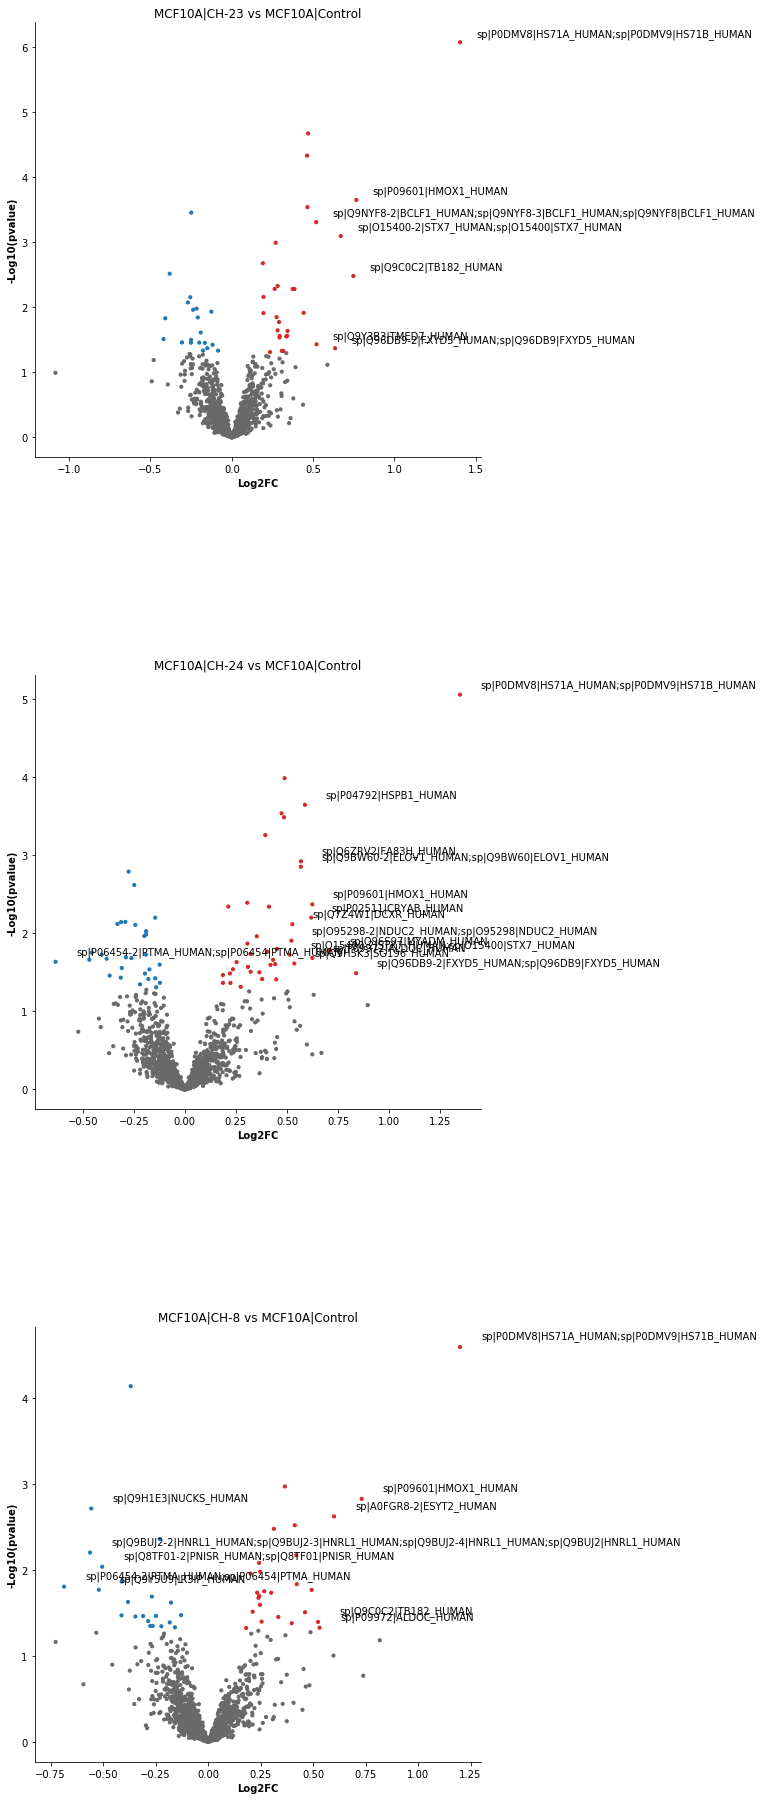

In [12]:
result = pd.read_csv('./MCF10A_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 0)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < 0)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 0.5)].iterrows():
        ax.annotate(row['Protein'], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

### compare with article given 
#### The total protein given in the article and our MCF10 total protein intersection is 743. We can quantified more proteins (624). Because the article does not give the threshold of FC, the total difference protein of the article cannot be obtained . Among them, the top 20 differential expressed protein intersection in the case of MCF10A CH-1 is 7

In [13]:
# map protein to gene name
import re
import urllib.parse
import urllib.request
from collections import OrderedDict

def MapProtGeneName(prots):
    url = 'https://www.uniprot.org/uploadlists/'
    query = ' '.join(prots)
    params = {
    'from': 'ACC+ID',
    'to': 'GENENAME',
    'format': 'tab',
    'query':query
    }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
        data = response.decode('utf-8')
        r = OrderedDict()
        keys = re.split('\t|\n', data)[::2][1:-1]
        values = re.split('\t|\n', data)[1::2][1:]
        for i in range(len(keys)):
            pro_key = [p for p in prots if keys[i] in p.split(" ")][0]
            if pro_key in r:
                r[pro_key] = r[pro_key] + ";" + values[i]
            else:
                r[pro_key] = values[i]  
    return r
    

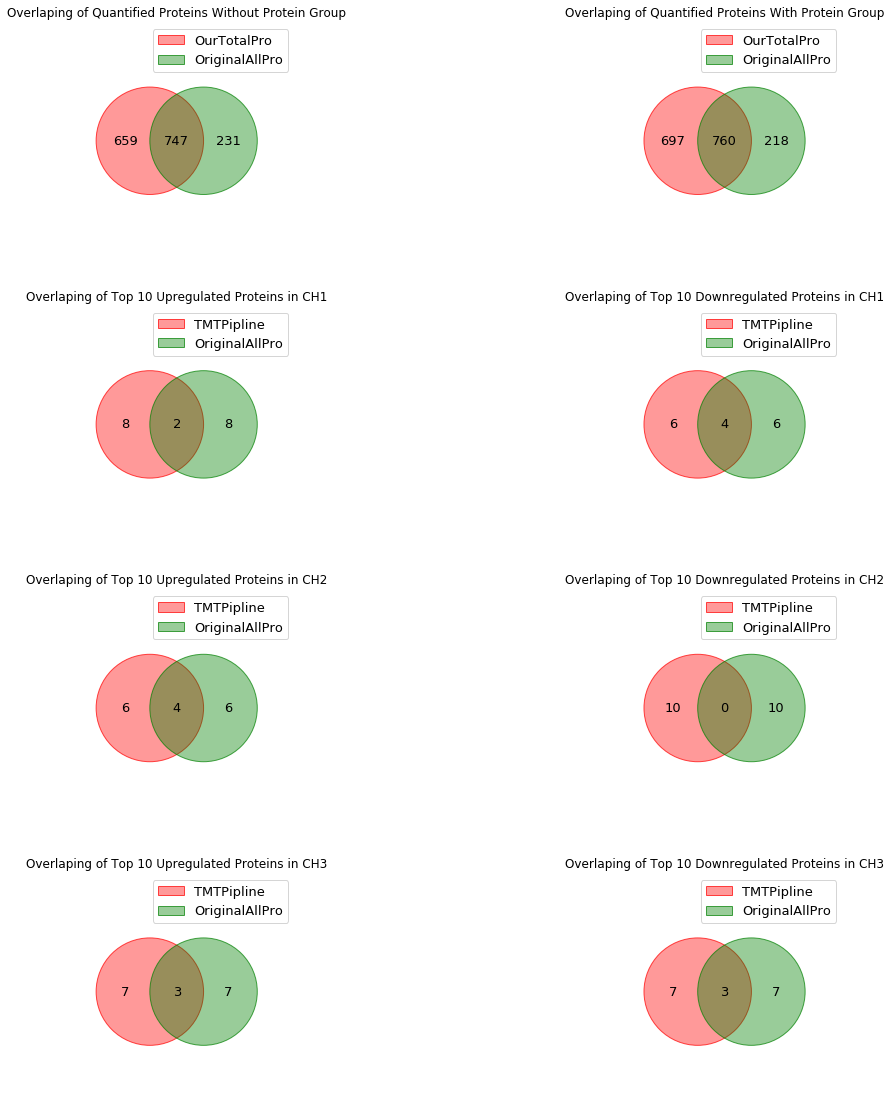

In [14]:
def split_proteingroup_preprocess(pro):
    # split the protein group
    if ";" in pro:
        t = []
        for p in pro.split(";"):
            t.append(p.split("|")[-1])
        return " ".join(set(t))
    else:
        return pro.split("|")[-1]

# 1. MCF10A  CH-23=CH-2  CH-8=CH-1  CH-24=CH-3
result = pd.read_csv('./MCF10A_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()

MCF10A_All = set(result['Protein'])
ProGeneMap = MapProtGeneName(list(map(split_proteingroup_preprocess, MCF10A_All)))

GeneNames = []
for _, row in result.iterrows():
    if split_proteingroup_preprocess(row['Protein']) in ProGeneMap:
        GeneNames.append(ProGeneMap[split_proteingroup_preprocess(row['Protein'])])
    else:
        GeneNames.append(row['Protein'])
result['GeneName'] = GeneNames
result.to_csv("./MCF10A_result.csv", sep=",", index=None)

# read data of the article
article_result = pd.read_excel("./Perseus results.xlsx", header=0, sheet_name="MCF10A")
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()

p1 = article_result['Gene names'].tolist()

_, axs = plt.subplots(ncols=2, nrows=4, figsize=(18, 20))
axs[0][0].set_title('Overlaping of Quantified Proteins Without Protein Group')
venn({'OurTotalPro': set(result["GeneName"]), 'OriginalAllPro': set(p1)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[0][0])

axs[0][1].set_title('Overlaping of Quantified Proteins With Protein Group')
venn({'OurTotalPro': set(";".join(result['GeneName'].tolist()).split(';')), 'OriginalAllPro': set(p1)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[0][1])

axs[1][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH1')
CH1 = result[(result['Label'] == 'MCF10A|CH-8 vs MCF10A|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['ME2', 'HIST3H2A', 'HMOX1', 'HSPA1B', 'HLA-C', 'HLA-A', 'ACBD3', 'HSPB1', 'B2M', 'P4HA1']
venn({'TMTPipline': set(CH1["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[1][0])

axs[1][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH1')
Top10Downregulated = ['HNRNPUL1', 'LUC7L3', 'S100A2', 'NUCKS1', 'PTMA', 'HMGN1', 'ETF1', 'BZW1', 'TXN2', 'EIF4B']
venn({'TMTPipline': set(CH1["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[1][1])

axs[2][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH2')
CH2 = result[(result['Label'] == 'MCF10A|CH-23 vs MCF10A|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['HSPA1B', 'HMOX1', 'SQSTM1', 'CRYAB', 'BAG3', 'HSPA6', 'P4HA1', 'HSPH1', 'HSP90AA1', 'HSPB1']
venn({'TMTPipline': set(CH2["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[2][0])

axs[2][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH2')
Top10Downregulated = ['GALNT2', 'INF2', 'DDX39A', 'PCNA', 'ACTB', 'EMG1', 'PSMD3', 'MT1E', 'EIF3D', 'DDX3X']
venn({'TMTPipline': set(CH2["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[2][1])

axs[3][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH3')
CH3 = result[(result['Label'] == 'MCF10A|CH-24 vs MCF10A|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['ME2', 'RPS27A', 'HSPA1B', 'HSPB1', 'HEATR1', 'CRYAB', 'HMOX1', 'SQSTM1', 'BAG3', 'HLA-A']
venn({'TMTPipline': set(CH3["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[3][0])

axs[3][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH3')
Top10Downregulated = ['HNRNPUL1', 'LUC7L3', 'PTMA','S100A2', 'HMGN1', 'EIF4B', 'OTUB1', 'NUCKS1', 'EIF4H', 'TNKS1BP1']
venn({'TMTPipline': set(CH3["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[3][1])


###  Protein expression Heatmaps

#### report: From the expression heat map, in line with the results of the article, the expressions of non-cancer cell lines MCF10A and MCF12A are similar. Cancer cell lines MDA-MB-231 and MDA-MB-468 have similar expressions

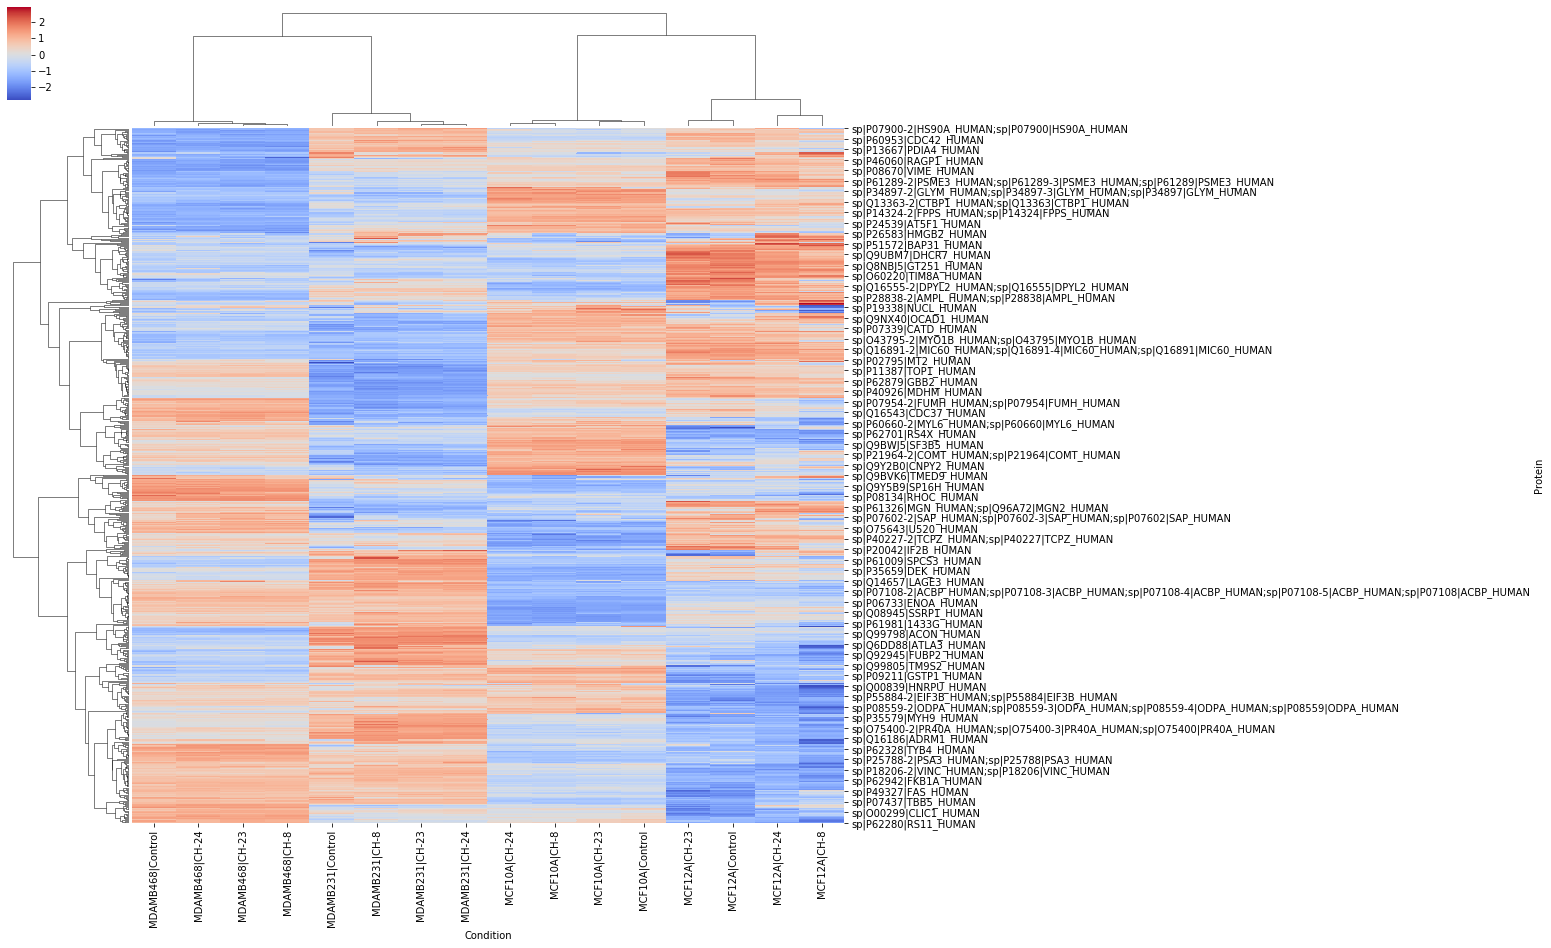

In [15]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
 
# Data set
url = './protein_expression.csv'
df = pd.read_csv(url)

df2 = df.pivot_table(index='Protein', columns='Condition', values='Abundance',aggfunc=np.mean)
df2 = df2.dropna()

# plot
g = sns.clustermap(df2, method='average', metric='correlation', z_score=0, figsize=(15,15), xticklabels=True, cmap="coolwarm")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels())#, fontsize = 5)

# tmp = g.ax_heatmap.get_xaxis()

threshold = 0.1
x_labels_ticks = g.ax_heatmap.get_xticklabels()

total_genes_above_threshold = 0
for i, xtickdata in enumerate(x_labels_ticks):
    protein = xtickdata._text
    if df2[protein].max() >= threshold:
        # print(df2[protein])
        # print("#########")
        total_genes_above_threshold = total_genes_above_threshold + 1
        # print(df2[protein].max())
    else:
        xtickdata._text = ''

#print("total_genes_above_threshold {}".format(total_genes_above_threshold))

# re set the tick labels with the modified list
g.ax_heatmap.set_xticklabels(x_labels_ticks)
plt.show()

### Visualization MCF12A Cell line Condition

In [16]:
%%R -w 1000 -h 600

MCF12A_Comp<-matrix(c(0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0, 1,0,0,0,1,-1,-1,-1,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),nrow=3)
row.names(MCF12A_Comp)<-c("MCF12A|CH-23 vs MCF12A|Control", "MCF12A|CH-24 vs MCF12A|Control", "MCF12A|CH-8 vs MCF12A|Control")
colnames(MCF12A_Comp) = c("MCF10A|CH-23","MCF10A|CH-24","MCF10A|CH-8","MCF10A|Control",
                        "MCF12A|CH-23","MCF12A|CH-24","MCF12A|CH-8","MCF12A|Control",
                        "MDAMB231|CH-23","MDAMB231|CH-24","MDAMB231|CH-8","MDAMB231|Control",
                        "MDAMB468|CH-23","MDAMB468|CH-24","MDAMB468|CH-8","MDAMB468|Control")
MCF12A.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix =MCF12A_Comp, moderated = TRUE)

write.table(MCF12A.pairwise$ComparisonResult,"MCF12A_result.csv",row.names=FALSE,col.names=TRUE,sep=",")



INFO  [2021-09-20 09:26:21] Model fitting for 2116 proteins.
  |======================================================================| 100%
INFO  [2021-09-20 09:28:45] Testing for 2116 proteins:
  |======================================================================| 100%


                    Protein                           Label    log2FC  \
3   sp|A0FGR8-2|ESYT2_HUMAN  MCF12A|CH-23 vs MCF12A|Control -0.005921   
4   sp|A0FGR8-2|ESYT2_HUMAN  MCF12A|CH-24 vs MCF12A|Control -0.311312   
5   sp|A0FGR8-2|ESYT2_HUMAN   MCF12A|CH-8 vs MCF12A|Control -0.281370   
9     sp|A6NHQ2|FBLL1_HUMAN  MCF12A|CH-23 vs MCF12A|Control -0.116575   
10    sp|A6NHQ2|FBLL1_HUMAN  MCF12A|CH-24 vs MCF12A|Control  0.152313   

      pvalue  -Log10(p-value)     group  
3   0.941274         0.026284   dimgrey  
4   0.005193         2.284597  tab:blue  
5   0.010020         1.999147  tab:blue  
9   0.558752         0.252781   dimgrey  
10  0.533844         0.272585   dimgrey  


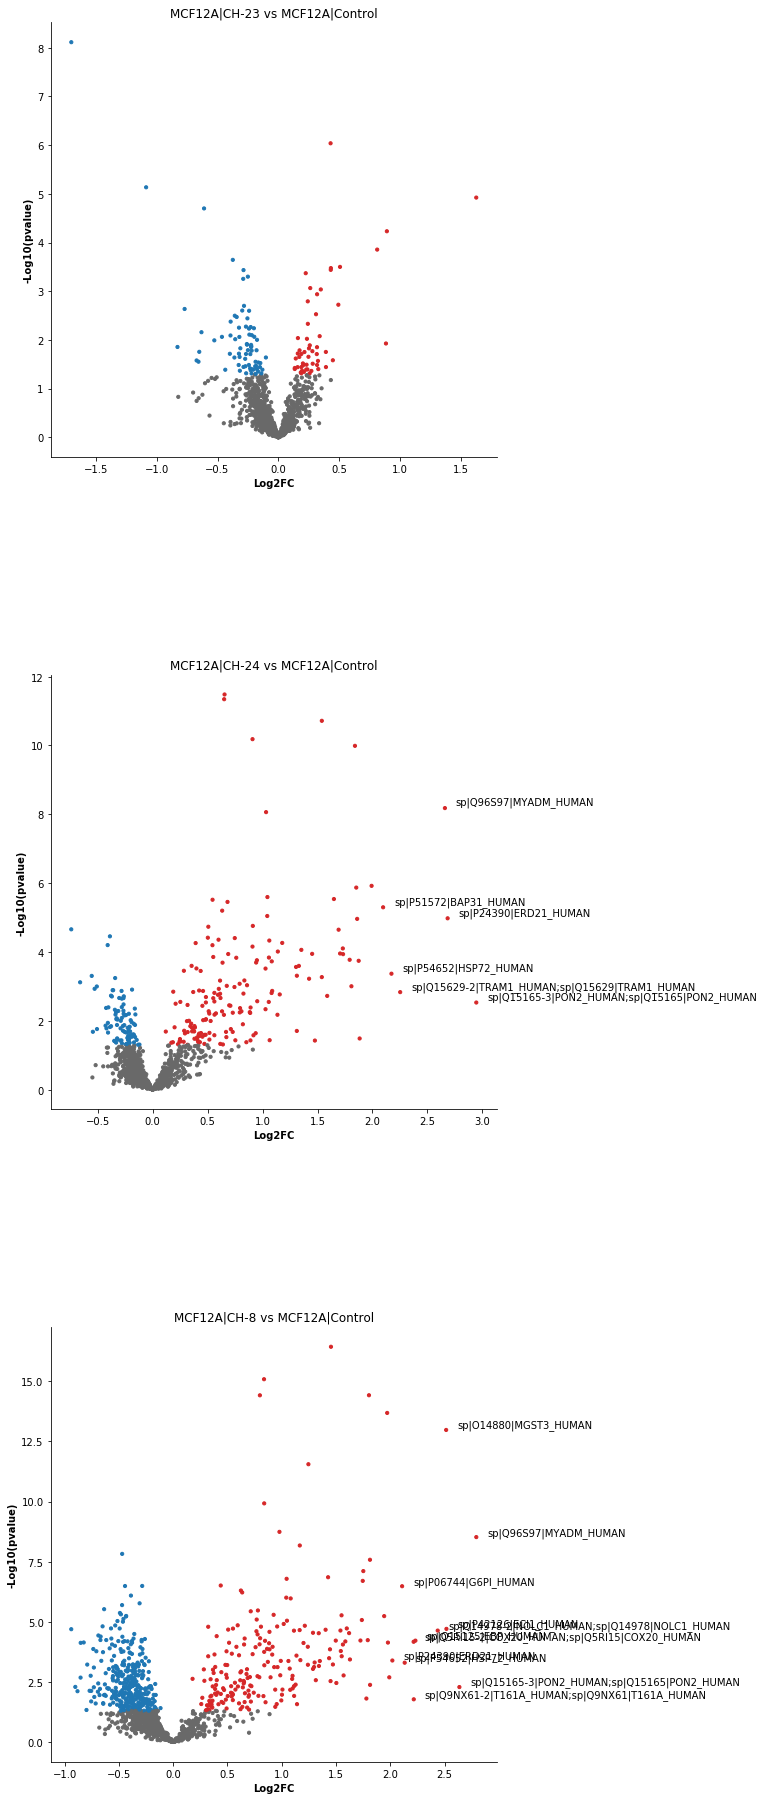

In [17]:
result = pd.read_csv('./MCF12A_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 0)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -0)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=20
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
     
    ax.set_title(comp)
    i += 1
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 2)].iterrows():
        ax.annotate(row['Protein'], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


#### We quantified more proteins and the most proteins given in the article are in our result. But they have less the shared top 10 differential expressed proteins. May be it's because we have half of unique quantified proteins 

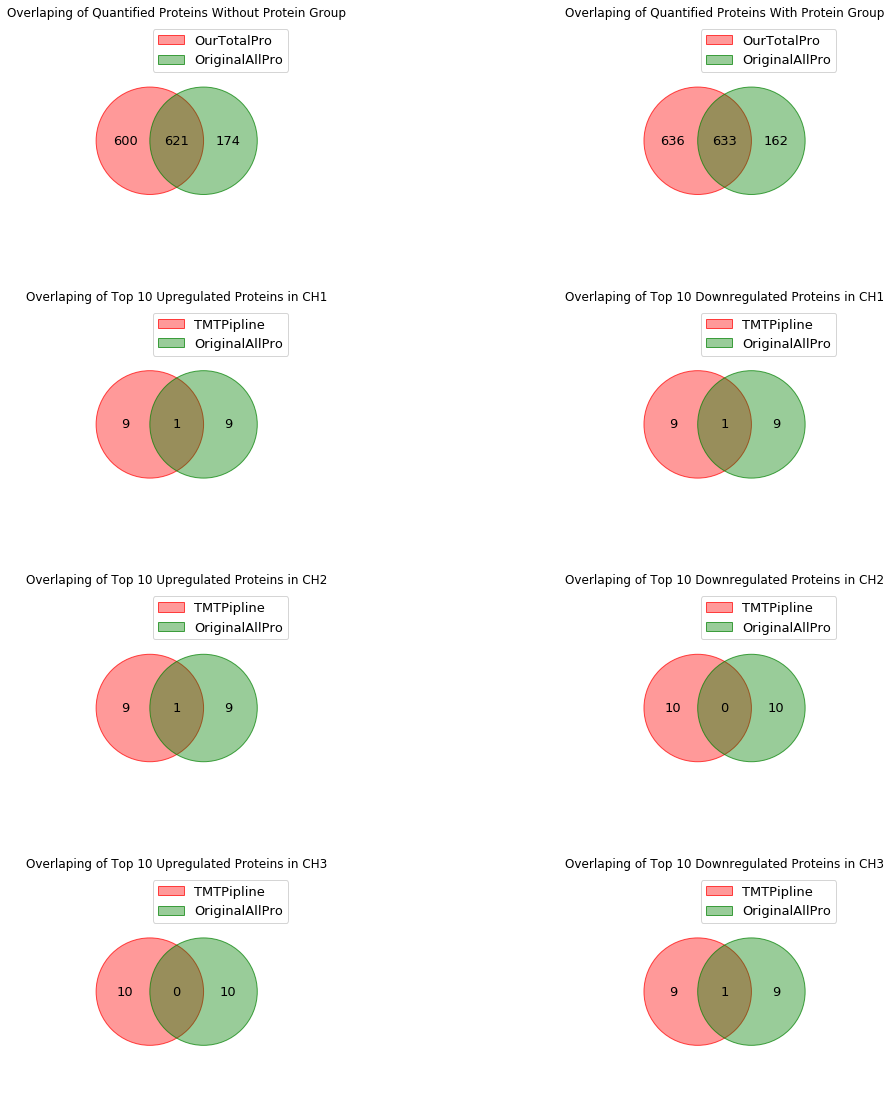

In [18]:
# TOP ten protein per condition comparison
# 1. MCF10A  CH-23=CH-2  CH-8=CH-1  CH-24=CH-3

result = pd.read_csv('./MCF12A_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
MCF12A_All = set(result['Protein'])
ProGeneMap = MapProtGeneName(list(map(split_proteingroup_preprocess, MCF12A_All)))

GeneNames = []
for _, row in result.iterrows():
    if split_proteingroup_preprocess(row['Protein']) in ProGeneMap:
        GeneNames.append(ProGeneMap[split_proteingroup_preprocess(row['Protein'])])
    else:
        GeneNames.append(row['Protein'])
result['GeneName'] = GeneNames
result.to_csv("./MCF12A_result.csv", sep=",", index=None)

# read data of the article
article_result = pd.read_excel("./Perseus results.xlsx", header=0, sheet_name="MCF12A")
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()

p1 = article_result['Gene names'].tolist()

_, axs = plt.subplots(ncols=2, nrows=4, figsize=(18, 20))
axs[0][0].set_title('Overlaping of Quantified Proteins Without Protein Group')
venn({'OurTotalPro': set(result["GeneName"]), 'OriginalAllPro': set(p1)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[0][0])

axs[0][1].set_title('Overlaping of Quantified Proteins With Protein Group')
venn({'OurTotalPro': set(";".join(result['GeneName'].tolist()).split(';')), 'OriginalAllPro': set(p1)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[0][1])

article_top_10 = ['PITRM1', 'S100A6', 'SUPT16H', 'HSPA1B', 'CACYBP', 'HSPA6', 'PKD1', 'S100A2', 'RPS27A', 'BASP1', 'DNM1L', 'CCDC124', 'EFTUD2',
                 'NHP2L1', 'MYBBP1A', 'SPATS2L', 'HNRNPU', 'SNRNP200', 'SEC23A', 'CAMK2D']

axs[1][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH1')
CH1 = result[(result['Label'] == 'MCF12A|CH-8 vs MCF12A|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['RAB1B', 'CCAR1', 'CBX1', 'MCM7', 'MGST3', 'SURF4', 'RPN2', 'NSDHL', 'TSPO', 'NOP16']
venn({'TMTPipline': set(CH1["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[1][0])

axs[1][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH1')
Top10Downregulated = ['MEPCE', 'IKBIP', 'RPL35A', 'NUP98', 'FKBP4', 'RPL28', 'SRP9', 'MARCKS', 'GOLIM4', 'UBTF']
venn({'TMTPipline': set(CH1["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[1][1])

axs[2][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH2')
CH2 = result[(result['Label'] == 'MCF12A|CH-23 vs MCF12A|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['HSP90AB1', 'SRSF7', 'HSP90AA1', 'HSPA6', 'H3F3A', 'HMGA1', 'DNAJB1', 'NUCKS1', 'HMOX1', 'HSPA1B']
venn({'TMTPipline': set(CH2["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[2][0])

axs[2][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH2')
Top10Downregulated = [ 'NCEH1', 'HIST1H2AC', 'LAMP2','HIST2H3A', 'TUBB8', 'EPPK1', 'DSP', 'SRP14', 'NSDHL', 'TARDBP']
venn({'TMTPipline': set(CH2["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[2][1])

axs[3][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH3')
CH3 = result[(result['Label'] == 'MCF12A|CH-24 vs MCF12A|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['CACYBP', 'ACTR1A', 'HSPA1B', 'SQRDL', 'SUPT16H', 'FABP5', 'S100A6', 'CSTB', 'RPS27A', 'PITRM1']
venn({'TMTPipline': set(CH3["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[3][0])

axs[3][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH3')
Top10Downregulated = ['HIST1H2AC', 'REEP5', 'CHCHD2','TARDBP', 'SNRPB2', 'MRPL3', 'MT2A', 'RPL34', 'DSP', 'EGFR']
venn({'TMTPipline': set(CH3["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[3][1])


### Visualization MDAMB231 Cell line Condtion

In [19]:
%%R -w 1000 -h 600

MDAMB231_Comp<-matrix(c(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0, 1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0),nrow=3)
row.names(MDAMB231_Comp)<-c("MDAMB231|CH-23 vs MDAMB231|Control", "MDAMB231|CH-24 vs MDAMB231|Control", "MDAMB231|CH-8 vs MDAMB231|Control")
colnames(MDAMB231_Comp) = c("MCF10A|CH-23","MCF10A|CH-24","MCF10A|CH-8","MCF10A|Control",
                        "MCF12A|CH-23","MCF12A|CH-24","MCF12A|CH-8","MCF12A|Control",
                        "MDAMB231|CH-23","MDAMB231|CH-24","MDAMB231|CH-8","MDAMB231|Control",
                        "MDAMB468|CH-23","MDAMB468|CH-24","MDAMB468|CH-8","MDAMB468|Control")
MDAMB231.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix =MDAMB231_Comp, moderated = TRUE)

write.table(MDAMB231.pairwise$ComparisonResult,"MDAMB231_result.csv",row.names=FALSE,col.names=TRUE,sep=",")


INFO  [2021-09-20 09:30:46] Model fitting for 2116 proteins.
  |======================================================================| 100%
INFO  [2021-09-20 09:33:14] Testing for 2116 proteins:
  |======================================================================| 100%


                                         Protein  \
0                           sp|A0AVT1|UBA6_HUMAN   
1                           sp|A0AVT1|UBA6_HUMAN   
2                           sp|A0AVT1|UBA6_HUMAN   
6  sp|A6NHL2-2|TBAL3_HUMAN;sp|A6NHL2|TBAL3_HUMAN   
7  sp|A6NHL2-2|TBAL3_HUMAN;sp|A6NHL2|TBAL3_HUMAN   

                                Label    log2FC    pvalue  -Log10(p-value)  \
0  MDAMB231|CH-23 vs MDAMB231|Control  0.084122  0.417728         0.379106   
1  MDAMB231|CH-24 vs MDAMB231|Control  0.037059  0.765647         0.115972   
2   MDAMB231|CH-8 vs MDAMB231|Control -0.059278  0.635317         0.197010   
6  MDAMB231|CH-23 vs MDAMB231|Control -0.378318  0.079360         1.100401   
7  MDAMB231|CH-24 vs MDAMB231|Control -0.427023  0.102876         0.987687   

     group  
0  dimgrey  
1  dimgrey  
2  dimgrey  
6  dimgrey  
7  dimgrey  


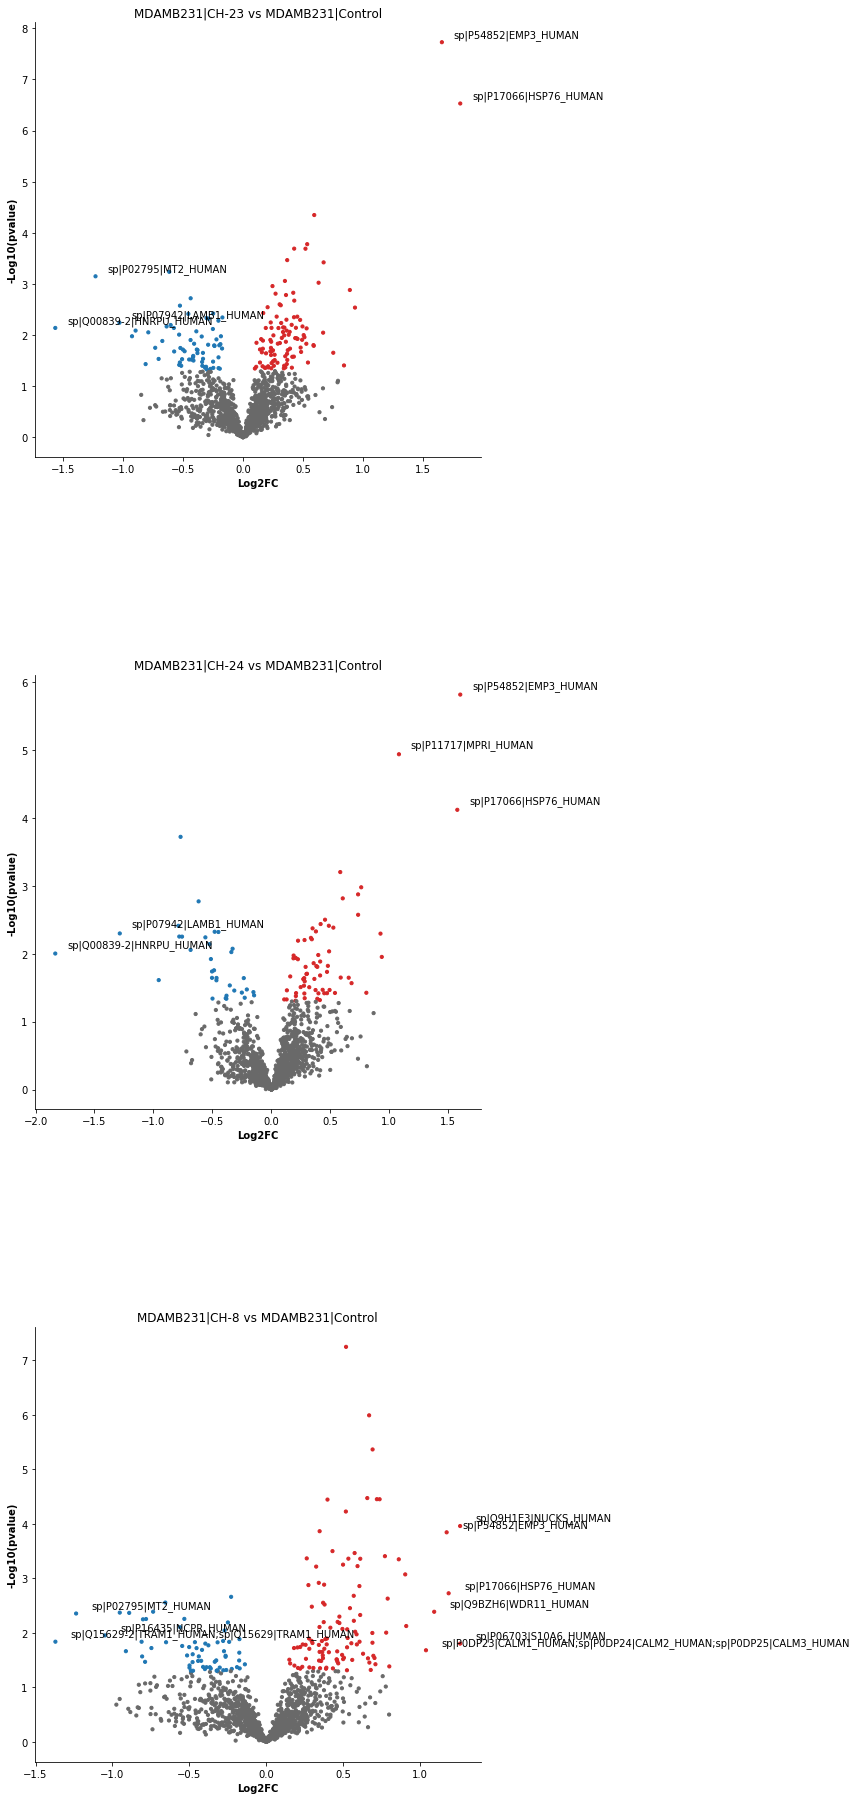

In [20]:
result = pd.read_csv('./MDAMB231_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 0)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -0)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=20
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
     
    ax.set_title(comp)
    i += 1
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 1)].iterrows():
        ax.annotate(row['Protein'], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

##### We quantified more proteins and the most proteins given in the article are in our result. But they have less the shared top 10 differential expressed proteins. 

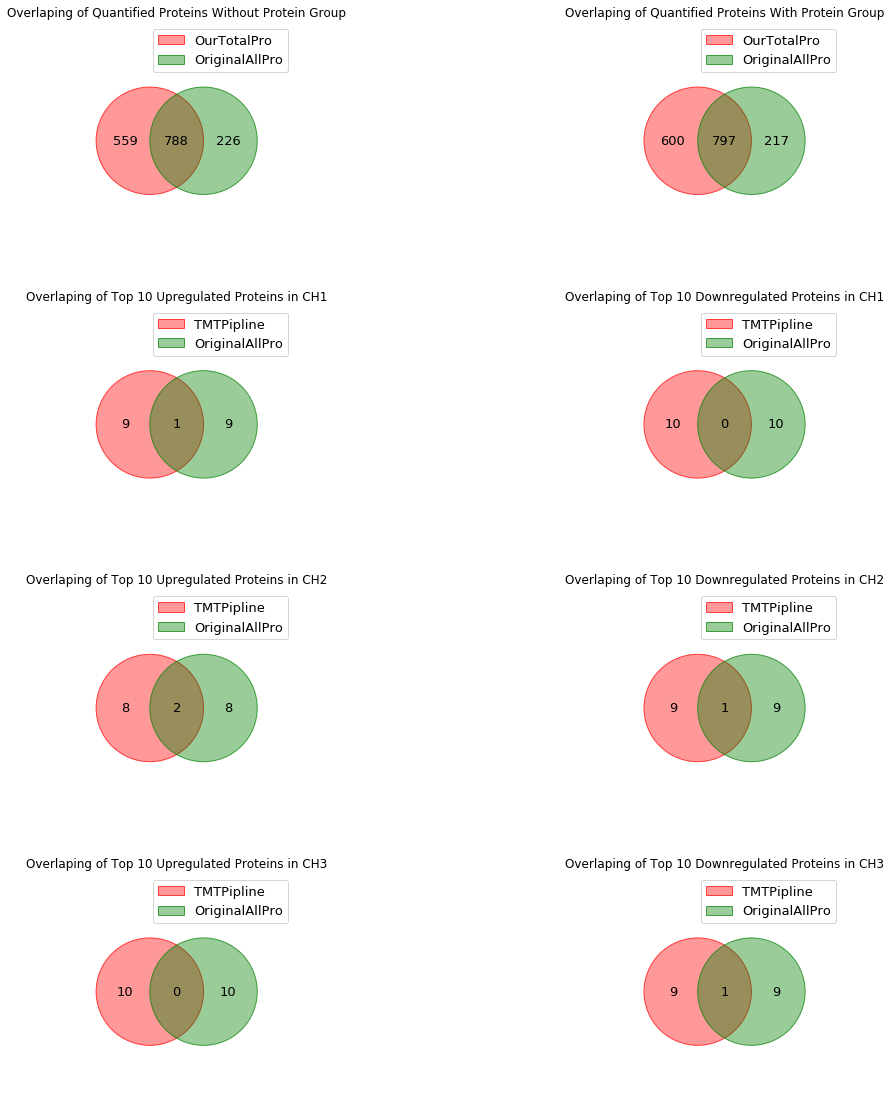

In [21]:
# TOP ten protein per condition comparison
# 1. MCF10A  CH-23=CH-2  CH-8=CH-1  CH-24=CH-3

result = pd.read_csv('./MDAMB231_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
MDAMB231_All = set(result['Protein'])
ProGeneMap = MapProtGeneName(list(map(split_proteingroup_preprocess, MDAMB231_All)))

GeneNames = []
for _, row in result.iterrows():
    if split_proteingroup_preprocess(row['Protein']) in ProGeneMap:
        GeneNames.append(ProGeneMap[split_proteingroup_preprocess(row['Protein'])])
    else:
        GeneNames.append(row['Protein'])
result['GeneName'] = GeneNames
result.to_csv("./MDAMB231_result.csv", sep=",", index=None)

# read data of the article
article_result = pd.read_excel("./Perseus results.xlsx", header=0, sheet_name="MDA-MB-231")
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()

p1 = article_result['Gene names'].tolist()

_, axs = plt.subplots(ncols=2, nrows=4, figsize=(18, 20))
axs[0][0].set_title('Overlaping of Quantified Proteins Without Protein Group')
venn({'OurTotalPro': set(result["GeneName"]), 'OriginalAllPro': set(p1)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[0][0])

axs[0][1].set_title('Overlaping of Quantified Proteins With Protein Group')
venn({'OurTotalPro': set(";".join(result['GeneName'].tolist()).split(';')), 'OriginalAllPro': set(p1)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[0][1])

article_top_10 = ['PITRM1', 'S100A6', 'SUPT16H', 'HSPA1B', 'CACYBP', 'HSPA6', 'PKD1', 'S100A2', 'RPS27A', 'BASP1', 'DNM1L', 'CCDC124', 'EFTUD2',
                 'NHP2L1', 'MYBBP1A', 'SPATS2L', 'HNRNPU', 'SNRNP200', 'SEC23A', 'CAMK2D']

axs[1][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH1')
CH1 = result[(result['Label'] == 'MDAMB231|CH-8 vs MDAMB231|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['BASP1', 'HSPE1', 'DBI', 'PTMA', 'S100A2', 'CSTB', 'HMGN2', 'HMGA1', 'S100A6', 'TMSB4X']
venn({'TMTPipline': set(CH1["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[1][0])

axs[1][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH1')
Top10Downregulated = ['DNM1L', 'CAMK2D', 'EFTUD2', 'SEC23A', 'MYH10', 'MYBBP1A', 'THOP1', 'ECE1', 'PRKAR1A', 'EIF4A2']

venn({'TMTPipline': set(CH1["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[1][1])

axs[2][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH2')
CH2 = result[(result['Label'] == 'MDAMB231|CH-23 vs MDAMB231|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['PITRM1', 'S100A6', 'SUPT16H', 'HSPA1B', 'CACYBP', 'HSPA6', 'PKD1', 'S100A2', 'RPS27A', 'BASP1']
venn({'TMTPipline': set(CH2["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[2][0])

axs[2][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH2')
Top10Downregulated = [ 'DNM1L', 'CCDC124', 'EFTUD2','NHP2L1', 'MYBBP1A', 'SPATS2L', 'HNRNPU', 'SNRNP200', 'SEC23A', 'CAMK2D']
venn({'TMTPipline': set(CH2["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[2][1])

axs[3][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH3')
CH3 = result[(result['Label'] == 'MDAMB231|CH-24 vs MDAMB231|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['CACYBP', 'ACTR1A', 'HSPA1B', 'SQRDL', 'SUPT16H', 'FABP5', 'S100A6', 'CSTB', 'RPS27A', 'PITRM1']
venn({'TMTPipline': set(CH3["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[3][0])

axs[3][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH3')
Top10Downregulated = ['DNM1L', 'NHP2L1', 'CAMK2D','HNRNPU', 'ALDOC', 'EFTUD2', 'SEC23A', 'TUBAL3', 'SPATS2L', 'MRPL12']
venn({'TMTPipline': set(CH3["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[3][1])

### Visualization MDMAB468 Cell Condition

In [22]:
%%R -w 1000 -h 600

MDAMB468_Comp<-matrix(c(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,1,0,0,0,1,0,0,0,1,-1,-1,-1),nrow=3)
row.names(MDAMB468_Comp)<-c("MDAMB468|CH-23 vs MDAMB468|Control", "MDAMB468|CH-24 vs MDAMB468|Control", "MDAMB468|CH-8 vs MDAMB468|Control")
colnames(MDAMB468_Comp) = c("MCF10A|CH-23","MCF10A|CH-24","MCF10A|CH-8","MCF10A|Control",
                        "MCF12A|CH-23","MCF12A|CH-24","MCF12A|CH-8","MCF12A|Control",
                        "MDAMB231|CH-23","MDAMB231|CH-24","MDAMB231|CH-8","MDAMB231|Control",
                        "MDAMB468|CH-23","MDAMB468|CH-24","MDAMB468|CH-8","MDAMB468|Control")
MDAMB468.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix =MDAMB468_Comp, moderated = TRUE)

write.table(MDAMB468.pairwise$ComparisonResult,"MDAMB468_result.csv",row.names=FALSE,col.names=TRUE,sep=",")


INFO  [2021-09-20 09:35:21] Model fitting for 2116 proteins.
  |======================================================================| 100%
INFO  [2021-09-20 09:37:53] Testing for 2116 proteins:
  |======================================================================| 100%


                                          Protein  \
6   sp|A6NHL2-2|TBAL3_HUMAN;sp|A6NHL2|TBAL3_HUMAN   
7   sp|A6NHL2-2|TBAL3_HUMAN;sp|A6NHL2|TBAL3_HUMAN   
8   sp|A6NHL2-2|TBAL3_HUMAN;sp|A6NHL2|TBAL3_HUMAN   
15                          sp|A8MUV8|ZN727_HUMAN   
16                          sp|A8MUV8|ZN727_HUMAN   

                                 Label    log2FC    pvalue  -Log10(p-value)  \
6   MDAMB468|CH-23 vs MDAMB468|Control -0.082517  0.773514         0.111532   
7   MDAMB468|CH-24 vs MDAMB468|Control -0.028446  0.935341         0.029030   
8    MDAMB468|CH-8 vs MDAMB468|Control -0.042758  0.902960         0.044331   
15  MDAMB468|CH-23 vs MDAMB468|Control  0.128000  0.486501         0.312917   
16  MDAMB468|CH-24 vs MDAMB468|Control -0.192320  0.399426         0.398564   

      group  
6   dimgrey  
7   dimgrey  
8   dimgrey  
15  dimgrey  
16  dimgrey  


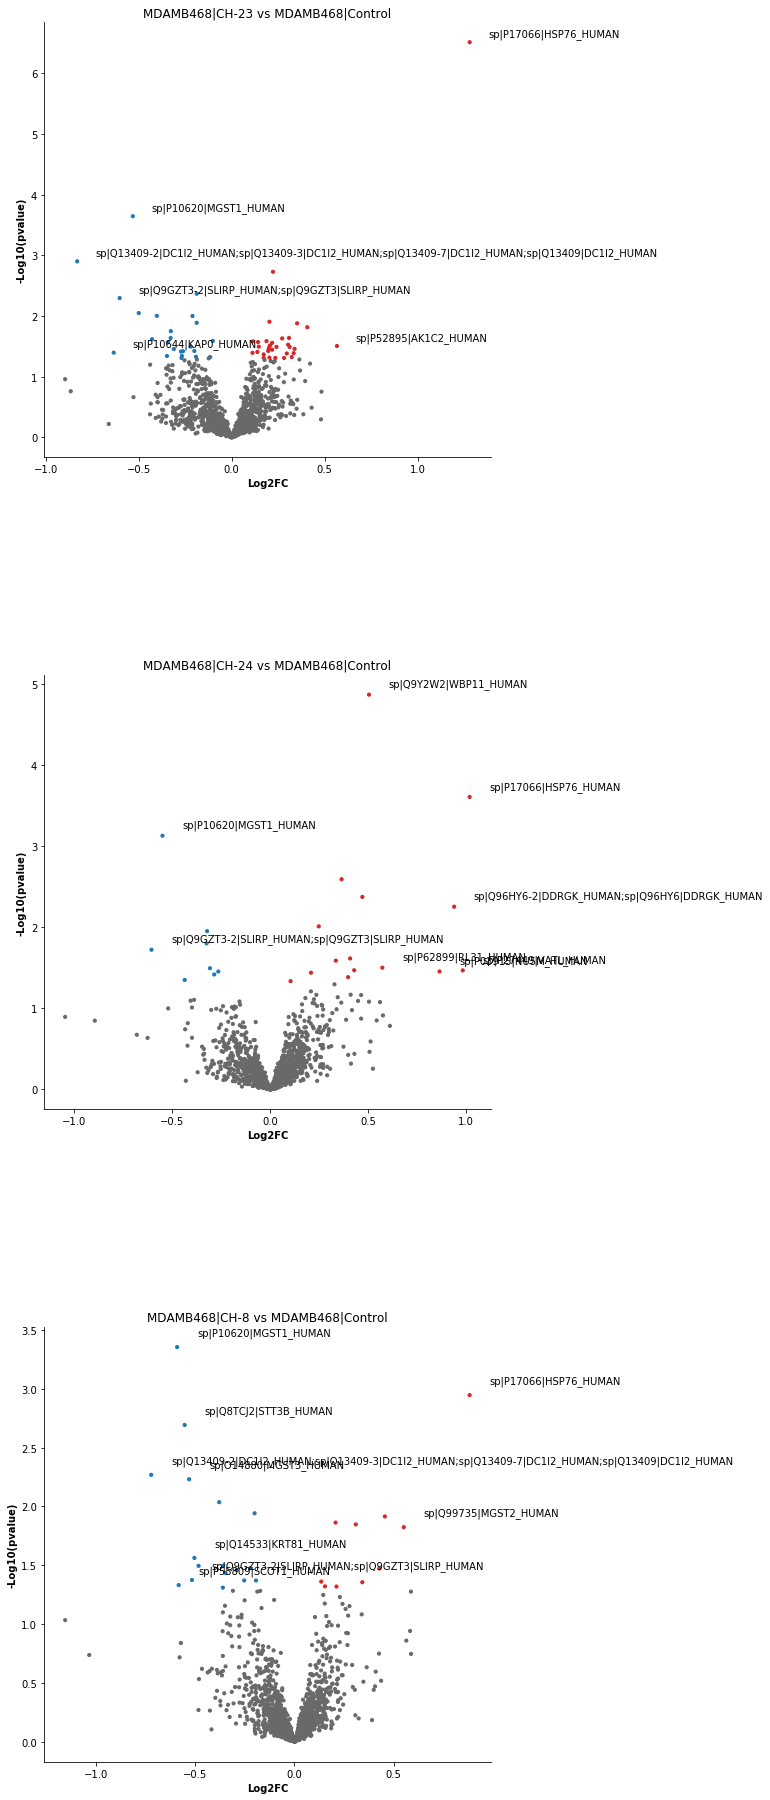

In [23]:
result = pd.read_csv('./MDAMB468_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 0)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -0)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=20
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
     
    ax.set_title(comp)
    i += 1
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 0.5)].iterrows():
        ax.annotate(row['Protein'], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

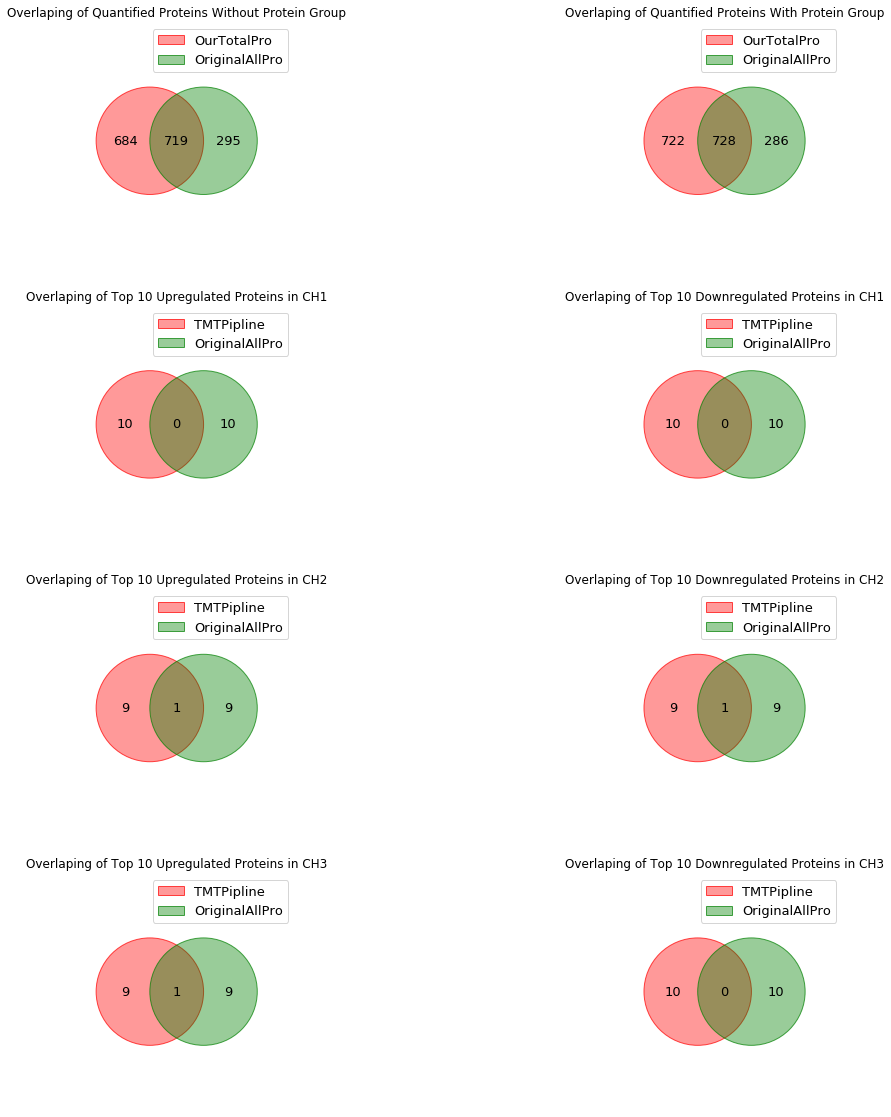

In [24]:
# TOP ten protein per condition comparison
# 1. MCF10A  CH-23=CH-2  CH-8=CH-1  CH-24=CH-3

result = pd.read_csv('./MDAMB468_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
MDAMB231_All = set(result['Protein'])
ProGeneMap = MapProtGeneName(list(map(split_proteingroup_preprocess, MDAMB231_All)))

GeneNames = []
for _, row in result.iterrows():
    if split_proteingroup_preprocess(row['Protein']) in ProGeneMap:
        GeneNames.append(ProGeneMap[split_proteingroup_preprocess(row['Protein'])])
    else:
        GeneNames.append(row['Protein'])
result['GeneName'] = GeneNames
result.to_csv("./MDAMB468_result.csv", sep=",", index=None)

# read data of the article
article_result = pd.read_excel("./Perseus results.xlsx", header=0, sheet_name="MDA-MB-231")
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()

p1 = article_result['Gene names'].tolist()

_, axs = plt.subplots(ncols=2, nrows=4, figsize=(18, 20))
axs[0][0].set_title('Overlaping of Quantified Proteins Without Protein Group')
venn({'OurTotalPro': set(result["GeneName"]), 'OriginalAllPro': set(p1)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[0][0])

axs[0][1].set_title('Overlaping of Quantified Proteins With Protein Group')
venn({'OurTotalPro': set(";".join(result['GeneName'].tolist()).split(';')), 'OriginalAllPro': set(p1)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[0][1])

article_top_10 = ['PITRM1', 'S100A6', 'SUPT16H', 'HSPA1B', 'CACYBP', 'HSPA6', 'PKD1', 'S100A2', 'RPS27A', 'BASP1', 'DNM1L', 'CCDC124', 'EFTUD2',
                 'NHP2L1', 'MYBBP1A', 'SPATS2L', 'HNRNPU', 'SNRNP200', 'SEC23A', 'CAMK2D']

axs[1][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH1')
CH1 = result[(result['Label'] == 'MDAMB468|CH-8 vs MDAMB468|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['BCLAF1', 'C1QBP', 'SEPT6', 'GCLM', 'EIF5B', 'RPL37A', 'EIF3J', 'HMOX1', 'EIF3M', 'PITRM1']
venn({'TMTPipline': set(CH1["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[1][0])

axs[1][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH1')
Top10Downregulated = ['EIF4A2', 'SRSF10', 'HIST2H2AA3', 'VIM', 'UBQLN4', 'PIP4K2C', 'DDX39A', 'GRN', 'PFKL', 'INF2']
venn({'TMTPipline': set(CH1["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[1][1])

axs[2][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH2')
CH2 = result[(result['Label'] == 'MDAMB468|CH-23 vs MDAMB468|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['YKT6', 'EIF3J', 'CACYBP', 'C1QBP', 'RPL37A', 'GCLM', 'HSPA1B', 'SEPT6', 'PITRM1', 'HMOX1']
venn({'TMTPipline': set(CH2["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[2][0])

axs[2][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH2')
Top10Downregulated = [ 'EIF4A2', 'SRSF10', 'UBQLN4','COPG2', 'PFKL', 'NUCB1', 'PRKAR1A', 'INF2', 'PSMG1', 'HIST2H2AA3']
venn({'TMTPipline': set(CH2["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[2][1])

axs[3][0].set_title('Overlaping of Top 10 Upregulated Proteins in CH3')
CH3 = result[(result['Label'] == 'MDAMB468|CH-24 vs MDAMB468|Control') & (result['pvalue'] < 0.05)].sort_values(['log2FC'], ascending=False)
Top10Upregulated = ['EIF3M', 'PITRM1', 'RPS27A', 'GCLM', 'S100A7', 'CKAP4', 'PIP4K2C', 'SEPT6', 'HMGN4', 'HMOX1']
venn({'TMTPipline': set(CH3["GeneName"].head(10)), 'OriginalAllPro': set(Top10Upregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[3][0])

axs[3][1].set_title('Overlaping of Top 10 Downregulated Proteins in CH3')
Top10Downregulated = ['UBQLN4', 'SRSF10', 'INF2', 'EIF4A2', 'IPO9', 'JUP', 'DHCR24', 'GSTO1', 'TROVE2', 'HIST2H2AA3']
venn({'TMTPipline': set(CH3["GeneName"].tail(10)), 'OriginalAllPro': set(Top10Downregulated)}, cmap=['r', 'g'], figsize=(9, 5), ax=axs[3][1])

### Calculte the CV in technical replicate

#### Our CV has fewer extreme values. Overall the CV values obtained from the reanalyses were similar to the originally published datasets

##### Original paper

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


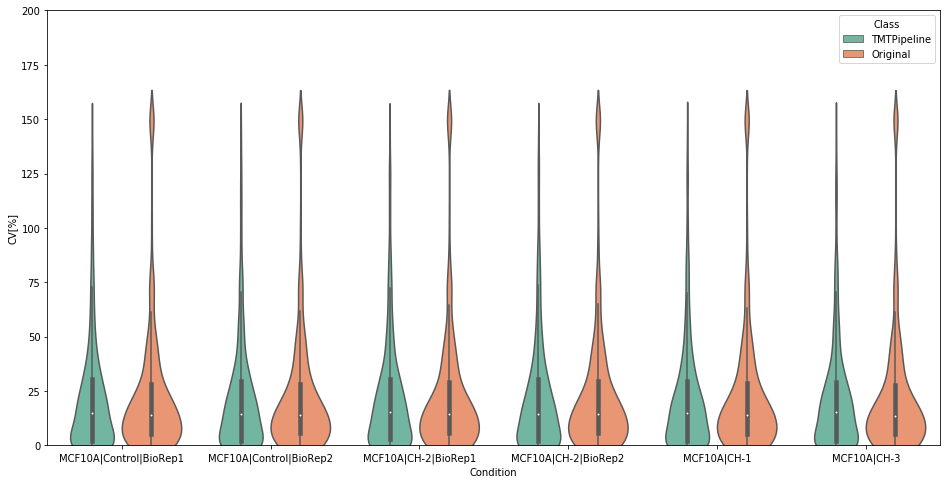

In [26]:
# In MCF10A cell lines experiment


outmsstats = pd.read_csv("./out_msstats_pre.csv", sep=",")
MCF10A_viodata = pd.DataFrame(columns=["Class", "Condition", "CV[%]"])

MCF10A = outmsstats[outmsstats["BioReplicate"] < 7]

MCF10AEve = pd.read_csv("./MCF10A_evidence.txt", sep="\t")
MCF12AEve = pd.read_csv("./MCF12A_evidence.txt", sep="\t")
MDAMB231Eve = pd.read_csv("./MDAMB231_evidence.txt", sep="\t")
MDAMB468Eve = pd.read_csv("./MDAMB468_evidence.txt", sep="\t")

# remove contaminant
MCF10AEve = MCF10AEve[(MCF10AEve["Reverse"] != "+") & (MCF10AEve["Potential contaminant"] != "+")]
MCF12AEve = MCF12AEve[(MCF10AEve["Reverse"] != "+") & (MCF12AEve["Potential contaminant"] != "+")]
MDAMB231Eve = MDAMB231Eve[(MDAMB231Eve["Reverse"] != "+") & (MDAMB231Eve["Potential contaminant"] != "+")]
MDAMB468Eve = MDAMB468Eve[(MDAMB468Eve["Reverse"] != "+") & (MDAMB468Eve["Potential contaminant"] != "+")]

for BioRname, group in MCF10A.groupby(["BioReplicate"]):
    for ProName, group in group.groupby(["ProteinName"]):
        if BioRname == 1:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF10A_viodata = MCF10A_viodata.append({"Class":"TMTPipeline", "Condition": "MCF10A|Control|BioRep1",
                                                         "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
        elif BioRname == 2:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF10A_viodata = MCF10A_viodata.append({"Class": "TMTPipeline", "Condition": "MCF10A|Control|BioRep2",
                                                         "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

        elif BioRname == 3:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF10A_viodata = MCF10A_viodata.append({"Class":"TMTPipeline", "Condition": "MCF10A|CH-2|BioRep1",
                                                         "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 4:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF10A_viodata = MCF10A_viodata.append({"Class":"TMTPipeline", "Condition": "MCF10A|CH-2|BioRep2",
                                                         "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 5:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF10A_viodata = MCF10A_viodata.append({"Class":"TMTPipeline", "Condition": "MCF10A|CH-1",
                                                         "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 6:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF10A_viodata = MCF10A_viodata.append({"Class":"TMTPipeline", "Condition": "MCF10A|CH-3",
                                                        "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

# MCF10A
for name, group in MCF10AEve.groupby(["Proteins"]):
    # control BioRep1
    t = group["Reporter intensity corrected 0"].tolist()
    std = np.std(t)
    mean = np.sum(t) / 3.0    
    if mean != 0.0:
        MCF10A_viodata = MCF10A_viodata.append({"Class": "Original", "Condition": "MCF10A|Control|BioRep1",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

    # control BioRep2
    t = group["Reporter intensity corrected 1"].tolist()
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MCF10A_viodata = MCF10A_viodata.append({"Class": "Original", "Condition": "MCF10A|Control|BioRep2",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH2 BioRep1
    t = group["Reporter intensity corrected 2"].tolist() 
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MCF10A_viodata = MCF10A_viodata.append({"Class": "Original", "Condition": "MCF10A|CH-2|BioRep1",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH2 BioRep2
    t = group["Reporter intensity corrected 3"].tolist()  
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MCF10A_viodata = MCF10A_viodata.append({"Class": "Original", "Condition": "MCF10A|CH-2|BioRep2",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    # CH1
    t = group["Reporter intensity corrected 4"].tolist() 
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MCF10A_viodata= MCF10A_viodata.append({"Class": "Original", "Condition": "MCF10A|CH-1",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
        
    # CH3
    t = group["Reporter intensity corrected 5"].tolist()   
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MCF10A_viodata = MCF10A_viodata.append({"Class": "Original", "Condition": "MCF10A|CH-3",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

        
plt.figure(figsize=(16,8))
plt.ylim(0, 200)
sns.violinplot("Condition", "CV[%]", order=['MCF10A|Control|BioRep1','MCF10A|Control|BioRep2','MCF10A|CH-2|BioRep1',
                                         'MCF10A|CH-2|BioRep2', 'MCF10A|CH-1', 'MCF10A|CH-3'], data=MCF10A_viodata,
               hue="Class", scale= "count", palette="Set2")
plt.show()
    

#### MCF12A

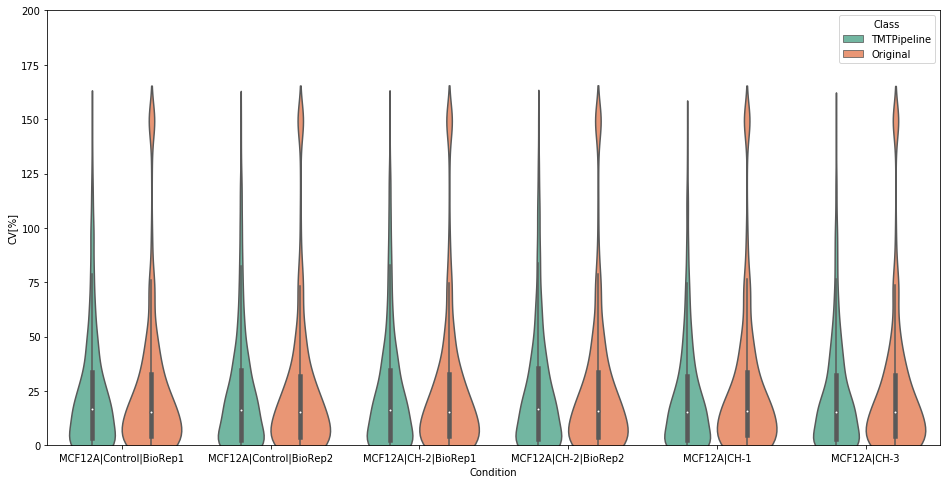

In [27]:
MCF12A_viodata = pd.DataFrame(columns=["Class", "Condition", "CV[%]"])    
 
MCF12A = outmsstats[(outmsstats["BioReplicate"] < 13) & ( 6 < outmsstats["BioReplicate"])]   
for BioRname, group in MCF12A.groupby(["BioReplicate"]):
    for ProName, group in group.groupby(["ProteinName"]):
        if BioRname == 7:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF12A_viodata = MCF12A_viodata.append({"Class":"TMTPipeline", "Condition": "MCF12A|Control|BioRep1",
                                                         "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
        elif BioRname == 8:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF12A_viodata = MCF12A_viodata.append({"Class": "TMTPipeline", "Condition": "MCF12A|Control|BioRep2",
                                                         "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

        elif BioRname == 9:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF12A_viodata = MCF12A_viodata.append({"Class":"TMTPipeline", "Condition": "MCF12A|CH-2|BioRep1",
                                                         "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 10:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF12A_viodata = MCF12A_viodata.append({"Class":"TMTPipeline", "Condition": "MCF12A|CH-2|BioRep2",
                                                         "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 11:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF12A_viodata = MCF12A_viodata.append({"Class":"TMTPipeline", "Condition": "MCF12A|CH-1",
                                                         "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 12:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MCF12A_viodata = MCF12A_viodata.append({"Class":"TMTPipeline", "Condition": "MCF12A|CH-3",
                                                        "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

# MCF12A
for name, group in MCF12AEve.groupby(["Proteins"]):
    # control BioRep1
    t = group["Reporter intensity corrected 0"].tolist()
    std = np.std(t)
    mean = np.sum(t) / 3.0   
    if mean != 0.0:
        MCF12A_viodata = MCF12A_viodata.append({"Class": "Original", "Condition": "MCF12A|Control|BioRep1",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

    # control BioRep2
    t = group["Reporter intensity corrected 1"].tolist()
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MCF12A_viodata = MCF12A_viodata.append({"Class": "Original", "Condition": "MCF12A|Control|BioRep2",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH2 BioRep1
    t = group["Reporter intensity corrected 2"].tolist() 
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MCF12A_viodata = MCF12A_viodata.append({"Class": "Original", "Condition": "MCF12A|CH-2|BioRep1",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH2 BioRep2
    t = group["Reporter intensity corrected 3"].tolist()  
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MCF12A_viodata = MCF12A_viodata.append({"Class": "Original", "Condition": "MCF12A|CH-2|BioRep2",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    # CH1
    t = group["Reporter intensity corrected 4"].tolist() 
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MCF12A_viodata= MCF12A_viodata.append({"Class": "Original", "Condition": "MCF12A|CH-1",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
        
    # CH3
    t = group["Reporter intensity corrected 5"].tolist()   
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MCF12A_viodata = MCF12A_viodata.append({"Class": "Original", "Condition": "MCF12A|CH-3",
                                                "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

        
plt.figure(figsize=(16,8))
plt.ylim(0, 200)
sns.violinplot("Condition", "CV[%]", order=['MCF12A|Control|BioRep1','MCF12A|Control|BioRep2','MCF12A|CH-2|BioRep1',
                                         'MCF12A|CH-2|BioRep2', 'MCF12A|CH-1', 'MCF12A|CH-3'], data=MCF12A_viodata,
               hue="Class", scale= "count", palette="Set2")
plt.show()

### MDAMB231

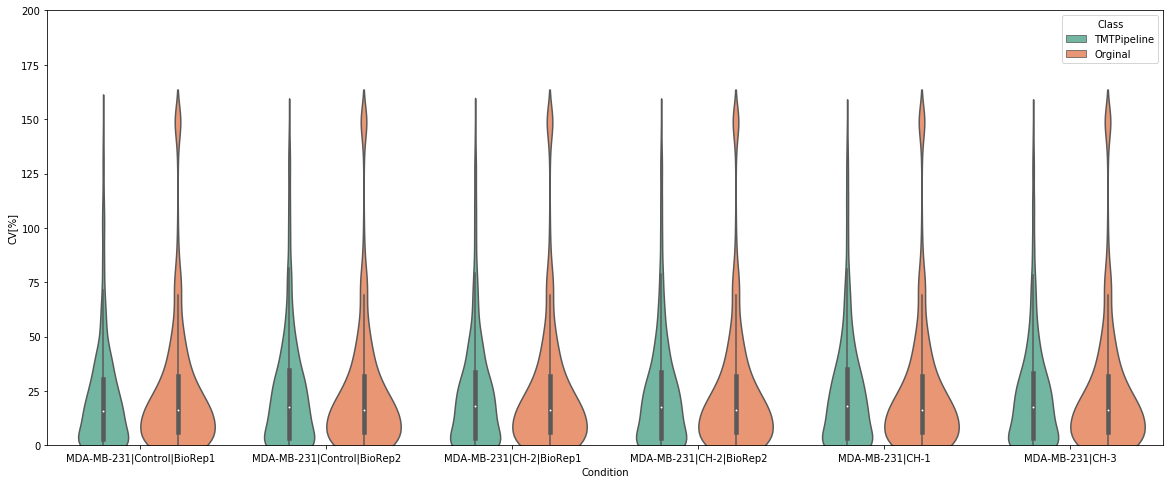

In [28]:
MDAMB231_viodata = pd.DataFrame(columns=["Class", "Condition", "CV[%]"])    
MDAMB231 = outmsstats[(outmsstats["BioReplicate"] < 19) & ( 12 < outmsstats["BioReplicate"])]    
for BioRname, group in MDAMB231.groupby(["BioReplicate"]):
    for ProName, group in group.groupby(["ProteinName"]):
        if BioRname == 13:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB231_viodata = MDAMB231_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-231|Control|BioRep1",
                                                             "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
        elif BioRname == 14:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB231_viodata = MDAMB231_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-231|Control|BioRep2",
                                                            "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

        elif BioRname == 15:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB231_viodata = MDAMB231_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-231|CH-2|BioRep1",
                                                             "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 16:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB231_viodata = MDAMB231_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-231|CH-2|BioRep2",
                                                             "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 17:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB231_viodata = MDAMB231_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-231|CH-1",
                                                             "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 18:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB231_viodata = MDAMB231_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-231|CH-3",
                                                            "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
                
for name, group in MDAMB231Eve.groupby(["Proteins"]):
    # control BioRep1
    t = group["Reporter intensity corrected 0"].tolist()
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB231_viodata = MDAMB231_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-231|Control|BioRep1",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

    
    # control BioRep2
    t = group["Reporter intensity corrected 0"].tolist()
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB231_viodata = MDAMB231_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-231|Control|BioRep2",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH1
    t = group["Reporter intensity corrected 0"].tolist()  
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB231_viodata = MDAMB231_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-231|CH-2|BioRep1",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH2 BioRep1
    t = group["Reporter intensity corrected 0"].tolist()    
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB231_viodata = MDAMB231_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-231|CH-2|BioRep2",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH2 BioRep2
    t = group["Reporter intensity corrected 0"].tolist()   
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB231_viodata = MDAMB231_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-231|CH-1",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH3
    t = group["Reporter intensity corrected 0"].tolist()
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB231_viodata = MDAMB231_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-231|CH-3",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)



plt.figure(figsize=(20,8))
plt.ylim(0, 200)
sns.violinplot(x = "Condition", y="CV[%]", data=MDAMB231_viodata, hue="Class", scale= "count", palette="Set2")
plt.show()


### MDAMB468

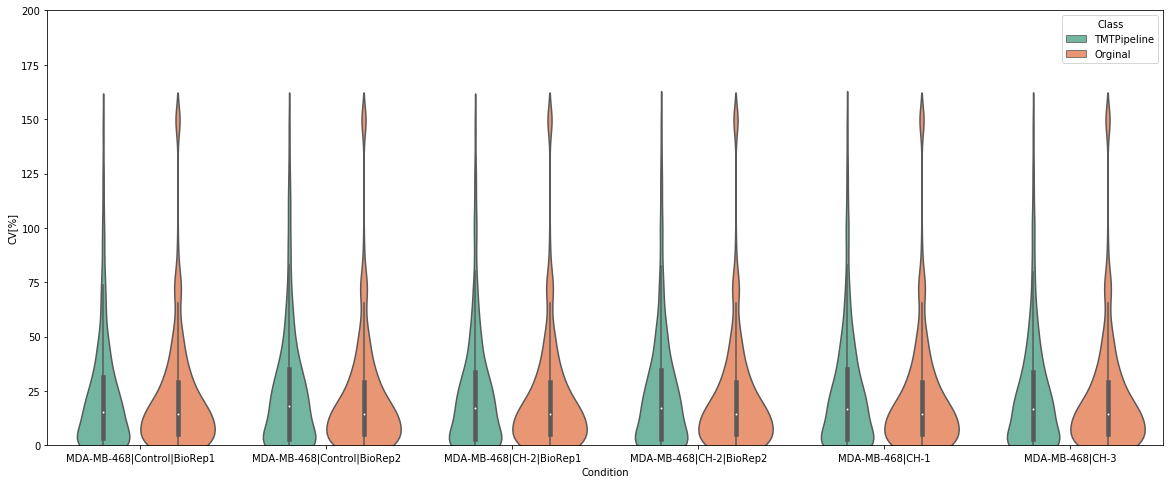

In [30]:
MDAMB468_viodata = pd.DataFrame(columns=["Class", "Condition", "CV[%]"])    
MDAMB468 = outmsstats[18 < outmsstats["BioReplicate"]]    
for BioRname, group in MDAMB468.groupby(["BioReplicate"]):
    for ProName, group in group.groupby(["ProteinName"]):
        if BioRname == 19:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB468_viodata = MDAMB468_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-468|Control|BioRep1",
                                                             "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
        elif BioRname == 20:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB468_viodata = MDAMB468_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-468|Control|BioRep2",
                                                            "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

        elif BioRname == 21:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB468_viodata = MDAMB468_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-468|CH-2|BioRep1",
                                                             "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 22:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB468_viodata = MDAMB468_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-468|CH-2|BioRep2",
                                                             "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 23:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB468_viodata = MDAMB468_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-468|CH-1",
                                                             "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
            
        elif BioRname == 24:
            t = group["Intensity"].tolist()
            mean = np.sum(t) / 3.0
            std = np.std(t)
            if mean != 0.0:
                MDAMB468_viodata = MDAMB468_viodata.append({"Class": "TMTPipeline", "Condition": "MDA-MB-468|CH-3",
                                                            "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
                
for name, group in MDAMB468Eve.groupby(["Proteins"]):
    # control BioRep1
    t = group["Reporter intensity corrected 0"].tolist()
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB468_viodata = MDAMB468_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-468|Control|BioRep1",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)

    
    # control BioRep2
    t = group["Reporter intensity corrected 0"].tolist()
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB468_viodata = MDAMB468_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-468|Control|BioRep2",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH1
    t = group["Reporter intensity corrected 0"].tolist()
#     t.extend([0] * (3 - len(set(group["Raw file"]))))   
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB468_viodata = MDAMB468_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-468|CH-2|BioRep1",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH2 BioRep1
    t = group["Reporter intensity corrected 0"].tolist()
#     t.extend([0] * (3 - len(set(group["Raw file"]))))    
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB468_viodata = MDAMB468_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-468|CH-2|BioRep2",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH2 BioRep2
    t = group["Reporter intensity corrected 0"].tolist()
#     t.extend([0] * (3 - len(set(group["Raw file"]))))   
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB468_viodata = MDAMB468_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-468|CH-1",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)
    
    # CH3
    t = group["Reporter intensity corrected 0"].tolist()
#     t.extend([0] * (3 - len(set(group["Raw file"]))))   
    std = np.std(t)
    mean = np.sum(t) / 3.0
    if mean != 0.0:
        MDAMB468_viodata = MDAMB468_viodata.append({"Class": "Orginal", "Condition": "MDA-MB-468|CH-3",
                                                    "CV[%]": round(std / mean, 3) * 100}, ignore_index=True)



plt.figure(figsize=(20,8))
plt.ylim(0, 200)
sns.violinplot(x = "Condition", y="CV[%]", data=MDAMB468_viodata, hue="Class", scale= "count", palette="Set2")
plt.show()